In [1]:
from skimage import data
import matplotlib.colors as colors
import numpy as np
from scipy.fftpack import fft, ifft, fft2, ifft2, ifftshift, fftshift, fftfreq
import matplotlib.pyplot as plt

via stack overflow:
How to keep these straight? A few tricks to remember:

    fft and ifft always need inputs and give outputs whose origins are in the beginning. This should be easy to remember from experience.
    fftshift takes the beginning-origin that fft needs/makes and shifts origin to the center. Again, I tend to readily remember this because of muscle-memory from typing fftshift(fft(...)) a thousand times.
    Finally, the only remaining thing is to deduce that ifftshift is the inverse of fftshift: it takes centered-origin vectors/arrays and shifts the origin to the beginning.


In [2]:
# Create functions for centered 2D Fourier and Inverse Fourier Transform
def ft2(x):
    return ifftshift(fft2(fftshift(x)))

def ift2(X):
    return fftshift(ifft2(ifftshift(X)))

def crop_center(im,max_coords=None,wind_size=350):
    '''
    Crops square window out of the center of an array.
    
    Parameters
    ----------
    im: 2-dimensional image array
        Input array
    max_coords: tuple containing the center of the crop window in the form
        (row_max,col_max)
    wind_size: integer defining the half-size of the cropped array. i.e. the
        cropped image that is returned has a dimension of 
        (2*wind_size,2*wind_size)
    
    Returns
    -------
    im_crop: 2-d array cropped array of size (2*wind_size,2*wind_size)
    '''
    # Assign coordinates for cropping
    if max_coords:
        row_max,col_max = max_coords
    else:
        row_max,col_max = (im.shape[0]//2,im.shape[1]//2)
    
    # Try to crop the image. If the window is too big, throw an error
    try:
        if (row_max + wind_size > im.shape[0]) or (row_max - wind_size < 0) or (col_max + wind_size > im.shape[1]) or (col_max - wind_size < 0):
            raise Exception('Window size exceeds image size')
        else:
            im_crop = im[row_max-wind_size:row_max+wind_size,col_max-wind_size:col_max+wind_size]
    except Exception:
        raise
        
    return im_crop

Text(0.5, 1.0, 'Cameraman Image')

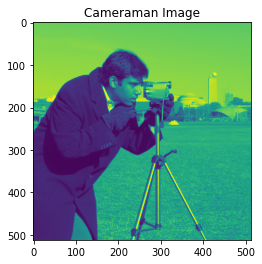

In [3]:
fig, ax = plt.subplots()
im_cameraman = data.camera()
ax.imshow(im_cameraman)
ax.set_title('Cameraman Image')

[[-256 -255 -254 ...  253  254  255]
 [-256 -255 -254 ...  253  254  255]
 [-256 -255 -254 ...  253  254  255]
 ...
 [-256 -255 -254 ...  253  254  255]
 [-256 -255 -254 ...  253  254  255]
 [-256 -255 -254 ...  253  254  255]]
(512, 512)
[[-256 -256 -256 ... -256 -256 -256]
 [-255 -255 -255 ... -255 -255 -255]
 [-254 -254 -254 ... -254 -254 -254]
 ...
 [ 253  253  253 ...  253  253  253]
 [ 254  254  254 ...  254  254  254]
 [ 255  255  255 ...  255  255  255]]
(512, 512)


Text(0.5, 1.0, 'Fourier Transform')

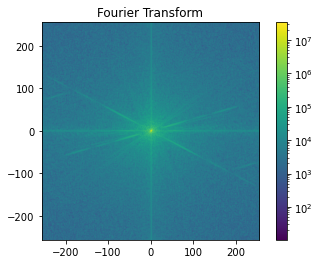

In [4]:
im_ft = fftshift(fft2(im_cameraman))
im_ftnoshift = fft2(im_cameraman)
fig, ax = plt.subplots()
x = np.arange(-256,256)
y = np.arange(-256,256)
X,Y = np.meshgrid(x,y)
print(X)
print(X.shape)
print(Y)
print(Y.shape)
him = ax.imshow(np.abs(im_ft), origin = "lower", norm=colors.LogNorm(), extent = [-256,255,-256,255])
fig.colorbar(him)
ax.set_title('Fourier Transform')

# What does meshgrid do?
Return coordinate matrices from coordinate vectors.

Inputs are coordinate vectors X, Y (1 dimensional)

if you get ouput X,Y = meshgrid(x,y)
then the X vector gives the X coordinate at any arbitrary point i,j. X[i,j] = x_0 and Y[i,j] = y_0 .

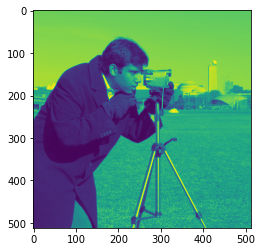

In [5]:
filtered_im = ifft2(im_ft)
fig, ax = plt.subplots()
ax.imshow(np.abs(filtered_im))

In [6]:
def make_mask(size, X,Y):
    newX = (abs(X) > abs(X/2-size))  
    newY = (abs(Y) > abs(Y/2-size)) 
    return newX + newY
      


Circular Mask Function

(512, 512)
[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
[[ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 ...
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]]


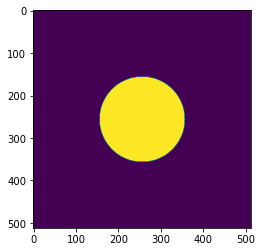

In [9]:
r = 100
print(X.shape)
x0 = 0
y0 = 0
low_pass_mask = ((X-x0)**2+(Y-y0)**2) <= r**2
sq_mask = make_mask(20,X,Y)
print(low_pass_mask)
print(sq_mask)
high_pass_mask = ((X-x0)**2+(Y-y0)**2) > r**2

fig, ax = plt.subplots()
ax.imshow(low_pass_mask)



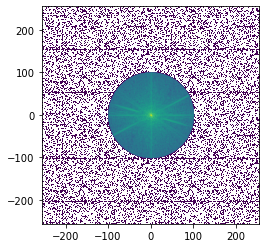

In [11]:
hmasked_ft = im_ft * high_pass_mask
lmasked_ft = im_ft * low_pass_mask
smasked_ft = im_ft * sq_mask
fig, ax = plt.subplots()
ax.imshow(np.abs(lmasked_ft), norm=colors.LogNorm(), extent = [-256,255,-256,255])


[[ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 ...
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]]


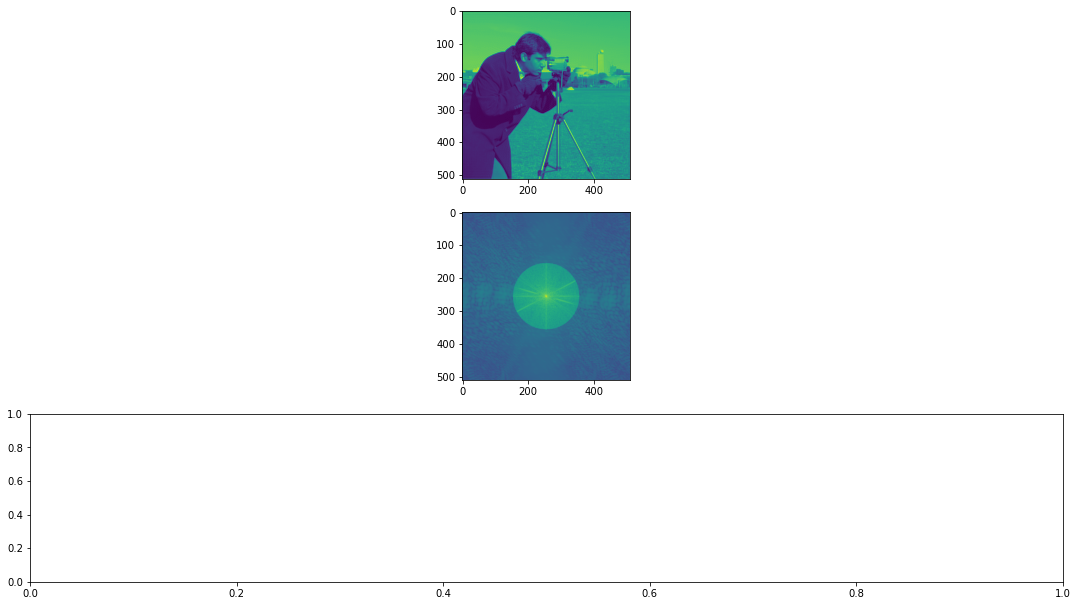

In [35]:
himage = (ifft2(lmasked_ft))
limage = fftshift(fft2(np.real(himage) * np.exp(1j * np.angle(himage))))
#limage = fft2(np.abs(himage))
limage2 = limage * low_pass_mask
print(limage2 == lmasked_ft)
fig,ax = plt.subplots(3)
fig.set_size_inches(18.5, 10.5)
ax[0].imshow(np.abs(himage))
ax[1].imshow(np.abs(limage), norm=colors.LogNorm())
